# Heart Disease Risk Prediction - Baseline Models Training

## Objective
Train and evaluate multiple baseline machine learning models for heart disease risk prediction using the processed ESS dataset.

## Apple Silicon Optimizations
This notebook is optimized for Mac M1/M2 Apple Silicon with:
- **PyTorch MPS acceleration** for Neural Network training
- **Optimized thread counts** for Random Forest and XGBoost
- **Memory-efficient configurations** for Apple Silicon architecture

## Models to Train
1. **Logistic Regression** - Linear baseline with interpretability
2. **Random Forest** - Tree-based ensemble method
3. **XGBoost** - Gradient boosting with high performance
4. **Support Vector Machine (SVM)** - Non-linear classification with RBF kernel
5. **Neural Network** - PyTorch implementation with AdamW optimizer

## Evaluation Metrics
- **Classification Metrics**: Accuracy, Precision, Recall, F1-score
- **Visual Analysis**: ROC curves, Confusion matrices
- **Detailed Reports**: Classification reports
- **Error Analysis**: Misclassified samples analysis

## Workflow
1. Load processed datasets and preprocessing artifacts
2. Train baseline models with cross-validation
3. Evaluate models using comprehensive metrics
4. Analyze misclassified samples for insights
5. Compare model performance and select best approaches

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os
from pathlib import Path
from datetime import datetime

# Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    make_scorer
)

# XGBoost
import xgboost as xgb

# PyTorch for Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Display and styling
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Apple Silicon optimizations
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)  # Set MPS seed for reproducibility
    print("Apple Silicon MPS optimizations enabled")

print("Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Modeling date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Apple Silicon MPS optimizations enabled
Libraries imported successfully
Pandas version: 2.3.3
Matplotlib version: 3.10.8
Seaborn version: 0.13.2
XGBoost version: 3.1.2
PyTorch version: 2.9.1
Modeling date: 2026-02-07 01:47


In [2]:
# Load processed datasets and preprocessing artifacts
print("LOADING PROCESSED DATASETS")
print("=" * 50)

# Load train/validation/test datasets
train_df = pd.read_csv("../data/processed/train.csv")
val_df = pd.read_csv("../data/processed/validation.csv")
test_df = pd.read_csv("../data/processed/test.csv")

# Load feature metadata
feature_names_df = pd.read_csv("../data/processed/feature_names.csv")
feature_names = feature_names_df['feature_name'].tolist()

# Load preprocessing artifacts
preprocessing_artifacts = joblib.load("../data/processed/preprocessing_artifacts.joblib")
scaler = preprocessing_artifacts['scaler']
feature_info = preprocessing_artifacts['feature_info']

print(f"Training set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")
print(f"Features: {len(feature_names)} predictors")

# Separate features and targets
X_train = train_df[feature_names]
y_train = train_df['hltprhc']

X_val = val_df[feature_names]
y_val = val_df['hltprhc']

X_test = test_df[feature_names]
y_test = test_df['hltprhc']

print(f"\nDATASET OVERVIEW:")
print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Features: {X_train.shape[1]}")

# Check class distribution
train_dist = y_train.value_counts(normalize=True)
print(f"\nClass distribution (training):")
for class_val, prop in train_dist.items():
    print(f"  Class {class_val}: {prop:.3f} ({prop*100:.1f}%)")

print(f"\nData loaded successfully - Ready for modeling!")

LOADING PROCESSED DATASETS
Training set: (25425, 23)
Validation set: (8476, 23)
Test set: (8476, 23)
Features: 22 predictors

DATASET OVERVIEW:
Training samples: 25,425
Validation samples: 8,476
Test samples: 8,476
Features: 22

Class distribution (training):
  Class 0: 0.887 (88.7%)
  Class 1: 0.113 (11.3%)

Data loaded successfully - Ready for modeling!


## Model Evaluation Framework Setup

In [3]:
# Comprehensive model evaluation framework
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    """
    Comprehensive model evaluation with multiple metrics
    """
    print(f"\nEvaluating {model_name}")
    print("-" * 40)
    
    # Cross-validation on training set
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    
    # Fit model and predict
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_proba_val = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    metrics = {
        'model_name': model_name,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std(),
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'train_precision': precision_score(y_train, y_pred_train),
        'train_recall': recall_score(y_train, y_pred_train),
        'train_f1': f1_score(y_train, y_pred_train),
        'val_accuracy': accuracy_score(y_val, y_pred_val),
        'val_precision': precision_score(y_val, y_pred_val),
        'val_recall': recall_score(y_val, y_pred_val),
        'val_f1': f1_score(y_val, y_pred_val),
        'val_auc': roc_auc_score(y_val, y_pred_proba_val)
    }
    
    # Print results
    print(f"Cross-validation F1: {metrics['cv_f1_mean']:.4f} ± {metrics['cv_f1_std']:.4f}")
    print(f"Training   - Acc: {metrics['train_accuracy']:.4f}, F1: {metrics['train_f1']:.4f}")
    print(f"Validation - Acc: {metrics['val_accuracy']:.4f}, F1: {metrics['val_f1']:.4f}, AUC: {metrics['val_auc']:.4f}")
    
    return model, metrics, y_pred_val, y_pred_proba_val

def plot_roc_curve(y_true, y_pred_proba, model_name, ax=None):
    """Plot ROC curve for a model"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

def plot_confusion_matrix(y_true, y_pred, model_name, normalize=True):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.3f' if normalize else 'd', 
                cmap='Blues', ax=ax, cbar_kws={'label': 'Proportion' if normalize else 'Count'})
    ax.set_title(f'{model_name} - Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    
    return fig, ax

print("Model evaluation framework setup complete")
print("Functions ready: evaluate_model, plot_roc_curve, plot_confusion_matrix")

Model evaluation framework setup complete
Functions ready: evaluate_model, plot_roc_curve, plot_confusion_matrix


## Baseline Model 1: Logistic Regression

In [4]:
# Train Logistic Regression baseline model
print("TRAINING LOGISTIC REGRESSION")
print("=" * 50)

# Initialize Logistic Regression with class balance handling
lr_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000,
    solver='liblinear'  # Good for small datasets
)

# Evaluate model
lr_fitted, lr_metrics, lr_pred_val, lr_pred_proba_val = evaluate_model(
    lr_model, X_train, X_val, y_train, y_val, "Logistic Regression"
)

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lr_fitted.coef_[0],
    'abs_coefficient': np.abs(lr_fitted.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print(f"\nTop 10 most important features:")
for i, (_, row) in enumerate(feature_importance_lr.head(10).iterrows()):
    print(f"  {i+1:2d}. {row['feature']:20s}: {row['coefficient']:8.4f}")

# Store results
model_results = [lr_metrics]
model_predictions = {'Logistic Regression': (lr_pred_val, lr_pred_proba_val)}

print(f"\nLogistic Regression training completed")

TRAINING LOGISTIC REGRESSION

Evaluating Logistic Regression
----------------------------------------
Cross-validation F1: 0.2836 ± 0.0058
Training   - Acc: 0.6576, F1: 0.2845
Validation - Acc: 0.6541, F1: 0.2901, AUC: 0.6890

Top 10 most important features:
   1. flteeff             :   0.3206
   2. bmi                 :   0.2960
   3. slprl               :   0.2078
   4. sclmeet             :  -0.1595
   5. happy               :   0.1417
   6. mental_health_score :  -0.1412
   7. wrhpp               :  -0.1333
   8. social_score        :   0.1170
   9. dosprt              :  -0.0973
  10. cgtsmok             :   0.0950

Logistic Regression training completed


## Baseline Model 2: Random Forest

In [5]:
# Train Random Forest model
print("TRAINING RANDOM FOREST")
print("=" * 50)

# Determine optimal number of jobs for Apple Silicon
import multiprocessing
n_cores = multiprocessing.cpu_count()
optimal_jobs = min(n_cores, 8)  # Apple Silicon benefits from moderate parallelization
print(f"Detected {n_cores} CPU cores, using {optimal_jobs} jobs for optimal performance")

# Initialize Random Forest with class balance handling
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=optimal_jobs  # Optimized for Apple Silicon
)

# Evaluate model
rf_fitted, rf_metrics, rf_pred_val, rf_pred_proba_val = evaluate_model(
    rf_model, X_train, X_val, y_train, y_val, "Random Forest"
)

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_fitted.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 most important features:")
for i, (_, row) in enumerate(feature_importance_rf.head(10).iterrows()):
    print(f"  {i+1:2d}. {row['feature']:20s}: {row['importance']:8.4f}")

# Update results
model_results.append(rf_metrics)
model_predictions['Random Forest'] = (rf_pred_val, rf_pred_proba_val)

print(f"\nRandom Forest training completed")

TRAINING RANDOM FOREST
Detected 8 CPU cores, using 8 jobs for optimal performance

Evaluating Random Forest
----------------------------------------
Cross-validation F1: 0.3054 ± 0.0087
Training   - Acc: 0.8648, F1: 0.5382
Validation - Acc: 0.7977, F1: 0.2893, AUC: 0.7006

Top 10 most important features:
   1. bmi                 :   0.1454
   2. dosprt              :   0.0931
   3. flteeff             :   0.0689
   4. lifestyle_score     :   0.0676
   5. mental_health_score :   0.0666
   6. slprl               :   0.0537
   7. cgtsmok             :   0.0486
   8. alcfreq             :   0.0475
   9. ctrlife             :   0.0424
  10. wrhpp               :   0.0388

Random Forest training completed


## Baseline Model 3: XGBoost

In [6]:
# Train XGBoost model
print("TRAINING XGBOOST")
print("=" * 50)

# Calculate class weights for imbalanced data
class_counts = np.bincount(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]

# Apple Silicon optimizations for XGBoost
optimal_threads = min(multiprocessing.cpu_count(), 8)
print(f"Using {optimal_threads} threads for XGBoost on Apple Silicon")

# Initialize XGBoost
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    n_jobs=optimal_threads,  # Optimized for Apple Silicon
    tree_method='hist'  # Faster on Apple Silicon
)

# Evaluate model
xgb_fitted, xgb_metrics, xgb_pred_val, xgb_pred_proba_val = evaluate_model(
    xgb_model, X_train, X_val, y_train, y_val, "XGBoost"
)

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_fitted.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 most important features:")
for i, (_, row) in enumerate(feature_importance_xgb.head(10).iterrows()):
    print(f"  {i+1:2d}. {row['feature']:20s}: {row['importance']:8.4f}")

# Update results
model_results.append(xgb_metrics)
model_predictions['XGBoost'] = (xgb_pred_val, xgb_pred_proba_val)

print(f"\nXGBoost training completed")

TRAINING XGBOOST
Using 8 threads for XGBoost on Apple Silicon

Evaluating XGBoost
----------------------------------------
Cross-validation F1: 0.2976 ± 0.0075
Training   - Acc: 0.8094, F1: 0.4941
Validation - Acc: 0.7373, F1: 0.3043, AUC: 0.6906

Top 10 most important features:
   1. dosprt              :   0.1052
   2. flteeff             :   0.0826
   3. slprl               :   0.0662
   4. wrhpp               :   0.0590
   5. cgtsmok             :   0.0499
   6. bmi                 :   0.0483
   7. alcfreq             :   0.0462
   8. enjlf               :   0.0450
   9. fltdpr              :   0.0435
  10. fltlnl              :   0.0433

XGBoost training completed


## Baseline Model 4: Support Vector Machine

In [7]:
# Train Support Vector Machine model
print("TRAINING SUPPORT VECTOR MACHINE")
print("=" * 50)

# Initialize SVM with RBF kernel and class balance handling
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True,  # Enable probability predictions for ROC
    random_state=42
)

# Evaluate model
svm_fitted, svm_metrics, svm_pred_val, svm_pred_proba_val = evaluate_model(
    svm_model, X_train, X_val, y_train, y_val, "Support Vector Machine"
)

# Update results
model_results.append(svm_metrics)
model_predictions['Support Vector Machine'] = (svm_pred_val, svm_pred_proba_val)

print(f"\nSupport Vector Machine training completed")
print("Note: SVM doesn't provide direct feature importance scores")

TRAINING SUPPORT VECTOR MACHINE

Evaluating Support Vector Machine
----------------------------------------
Cross-validation F1: 0.2979 ± 0.0065
Training   - Acc: 0.7664, F1: 0.4263
Validation - Acc: 0.7058, F1: 0.2951, AUC: 0.6863

Support Vector Machine training completed
Note: SVM doesn't provide direct feature importance scores


## Save Baseline Models

Save all trained baseline models to avoid retraining in future analysis.

In [8]:
# Create models directory if it doesn't exist
models_dir = "../results/models"
os.makedirs(models_dir, exist_ok=True)

print("SAVING BASELINE MODELS")
print("=" * 50)

# Check if models exist in the current session
baseline_models = {}
baseline_results = {}

# Collect all trained models and their metrics
try:
    if 'lr_fitted' in locals() and 'lr_metrics' in locals():
        baseline_models['logistic_regression'] = lr_fitted
        baseline_results['logistic_regression'] = {
            'model': lr_fitted,
            'metrics': lr_metrics,
            'predictions': lr_pred_val,
            'probabilities': lr_pred_proba_val,
            'timestamp': datetime.now().isoformat()
        }
        print("Logistic Regression model found")
    else:
        print("Logistic Regression model not found in current session")
        
except NameError:
    print("Logistic Regression variables not available")

try:
    if 'rf_fitted' in locals() and 'rf_metrics' in locals():
        baseline_models['random_forest'] = rf_fitted
        baseline_results['random_forest'] = {
            'model': rf_fitted,
            'metrics': rf_metrics,
            'predictions': rf_pred_val,
            'probabilities': rf_pred_proba_val,
            'feature_importance': feature_importance_rf,
            'timestamp': datetime.now().isoformat()
        }
        print("Random Forest model found")
    else:
        print("Random Forest model not found in current session")
        
except NameError:
    print("Random Forest variables not available")

try:
    if 'xgb_fitted' in locals() and 'xgb_metrics' in locals():
        baseline_models['xgboost'] = xgb_fitted
        baseline_results['xgboost'] = {
            'model': xgb_fitted,
            'metrics': xgb_metrics,
            'predictions': xgb_pred_val,
            'probabilities': xgb_pred_proba_val,
            'feature_importance': feature_importance_xgb,
            'timestamp': datetime.now().isoformat()
        }
        print("XGBoost model found")
    else:
        print("XGBoost model not found in current session")
        
except NameError:
    print("XGBoost variables not available")

try:
    if 'svm_fitted' in locals() and 'svm_metrics' in locals():
        baseline_models['svm'] = svm_fitted
        baseline_results['svm'] = {
            'model': svm_fitted,
            'metrics': svm_metrics,
            'predictions': svm_pred_val,
            'probabilities': svm_pred_proba_val,
            'timestamp': datetime.now().isoformat()
        }
        print("SVM model found")
    else:
        print("SVM model not found in current session")
        
except NameError:
    print("SVM variables not available")

# Neural Network is already saved, just reference it
try:
    if 'nn_metrics' in locals():
        print("Neural Network results already saved separately")
    else:
        print("Neural Network results not found")
except NameError:
    print("Neural Network variables not available")

# Save individual models
saved_models = []
for model_name, model_data in baseline_results.items():
    try:
        model_file = os.path.join(models_dir, f"{model_name}_baseline.joblib")
        joblib.dump(model_data, model_file)
        saved_models.append(model_name)
        print(f"{model_name.replace('_', ' ').title()} saved to: {model_file}")
    except Exception as e:
        print(f"Error saving {model_name}: {e}")

# Save comprehensive baseline results summary
baseline_summary = {
    'timestamp': datetime.now().isoformat(),
    'models_saved': saved_models,
    'model_metrics': {name: data['metrics'] for name, data in baseline_results.items()},
    'training_info': {
        'dataset_size': {
            'train': len(X_train),
            'val': len(X_val),
            'test': len(X_test)
        },
        'features': len(feature_names),
        'class_distribution': {
            'negative': (y_train == 0).sum(),
            'positive': (y_train == 1).sum(),
            'imbalance_ratio': (y_train == 0).sum() / (y_train == 1).sum()
        }
    },
    'optimization_settings': {
        'apple_silicon': True,
        'optimal_jobs': optimal_jobs,
        'optimal_threads': optimal_threads
    }
}

summary_file = os.path.join(models_dir, "baseline_models_summary.joblib")
joblib.dump(baseline_summary, summary_file)

print(f"\nBASELINE MODELS SUMMARY")
print("-" * 40)
print(f"Models directory: {models_dir}")
print(f"Models saved: {len(saved_models)}/{len(baseline_models) + 1}")  # +1 for Neural Network
print(f"Summary file: {summary_file}")

if saved_models:
    print(f"\nSuccessfully saved models:")
    for model in saved_models:
        print(f"   - {model.replace('_', ' ').title()}")

print(f"\nThese models can now be loaded in error analysis without retraining!")
print(f"Saved at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

SAVING BASELINE MODELS
Logistic Regression model found
Random Forest model found
XGBoost model found
SVM model found
Neural Network results not found
Logistic Regression saved to: ../results/models/logistic_regression_baseline.joblib
Random Forest saved to: ../results/models/random_forest_baseline.joblib
Xgboost saved to: ../results/models/xgboost_baseline.joblib
Svm saved to: ../results/models/svm_baseline.joblib

BASELINE MODELS SUMMARY
----------------------------------------
Models directory: ../results/models
Models saved: 4/5
Summary file: ../results/models/baseline_models_summary.joblib

Successfully saved models:
   - Logistic Regression
   - Random Forest
   - Xgboost
   - Svm

These models can now be loaded in error analysis without retraining!
Saved at: 2026-02-07 01:53:43


## Baseline Model 5: Neural Network (PyTorch)

In [13]:
# Load Neural Network results from trained Python script
print("LOADING NEURAL NETWORK RESULTS")
print("=" * 50)

import os
print(f"Current working directory: {os.getcwd()}")

try:
    # Try different path possibilities
    possible_paths = [
        "results/models/neural_network_results.joblib",
        "../results/models/neural_network_results.joblib",
        "/Users/peter/Desktop/heart_risk_prediction/results/models/neural_network_results.joblib"
    ]
    
    results_path = None
    for path in possible_paths:
        if os.path.exists(path):
            results_path = path
            break
    
    if results_path:
        print(f"Found results at: {results_path}")
        
        # Load the trained Neural Network results
        nn_results = joblib.load(results_path)
        
        # Extract results
        nn_metrics = nn_results['metrics']
        y_pred_val_nn = nn_results['val_predictions']
        y_pred_proba_val_nn = nn_results['val_probabilities']
        
        print(f"Neural Network results loaded successfully")
        print(f"Training completed: {nn_results['timestamp']}")
        print(f"Model trained using Apple Silicon MPS acceleration")
        
        # Display performance metrics
        print(f"\nNeural Network Performance:")
        print(f"  Training   - Acc: {nn_metrics['train_accuracy']:.4f}, Prec: {nn_metrics['train_precision']:.4f}, Rec: {nn_metrics['train_recall']:.4f}, F1: {nn_metrics['train_f1']:.4f}")
        print(f"  Validation - Acc: {nn_metrics['val_accuracy']:.4f}, Prec: {nn_metrics['val_precision']:.4f}, Rec: {nn_metrics['val_recall']:.4f}, F1: {nn_metrics['val_f1']:.4f}, AUC: {nn_metrics['val_auc']:.4f}")
        
        # Update results
        model_results.append(nn_metrics)
        model_predictions['Neural Network'] = (y_pred_val_nn, y_pred_proba_val_nn)
        
        print(f"\nNeural Network results integrated into model comparison")
    else:
        print("Neural Network results file not found in any expected location")
        print("Available paths checked:")
        for path in possible_paths:
            print(f"  - {path}: {'EXISTS' if os.path.exists(path) else 'NOT FOUND'}")
    
except Exception as e:
    print(f"Error loading Neural Network results: {e}")
    import traceback
    traceback.print_exc()

LOADING NEURAL NETWORK RESULTS
Current working directory: /Users/peter/Desktop/heart_risk_prediction/notebooks
Found results at: ../results/models/neural_network_results.joblib
Neural Network results loaded successfully
Training completed: 2026-02-07T02:01:49.997981
Model trained using Apple Silicon MPS acceleration

Neural Network Performance:
  Training   - Acc: 0.8110, Prec: 0.2888, Rec: 0.4585, F1: 0.3544
  Validation - Acc: 0.7941, Prec: 0.2484, Rec: 0.4046, F1: 0.3078, AUC: 0.6820

Neural Network results integrated into model comparison


## Comprehensive Model Evaluation and Comparison

BASELINE MODELS COMPARISON
Model Performance Summary:
            model_name  cv_f1_mean  val_accuracy  val_precision  val_recall  val_f1  val_auc
   Logistic Regression      0.2836        0.6541         0.1889      0.6246  0.2901   0.6890
         Random Forest      0.3054        0.7977         0.2400      0.3639  0.2893   0.7006
               XGBoost      0.2976        0.7373         0.2172      0.5078  0.3043   0.6906
Support Vector Machine      0.2979        0.7058         0.2024      0.5443  0.2951   0.6863
        Neural Network         NaN        0.7941         0.2484      0.4046  0.3078   0.6820

Best performing model: Neural Network (F1-score: 0.3078)


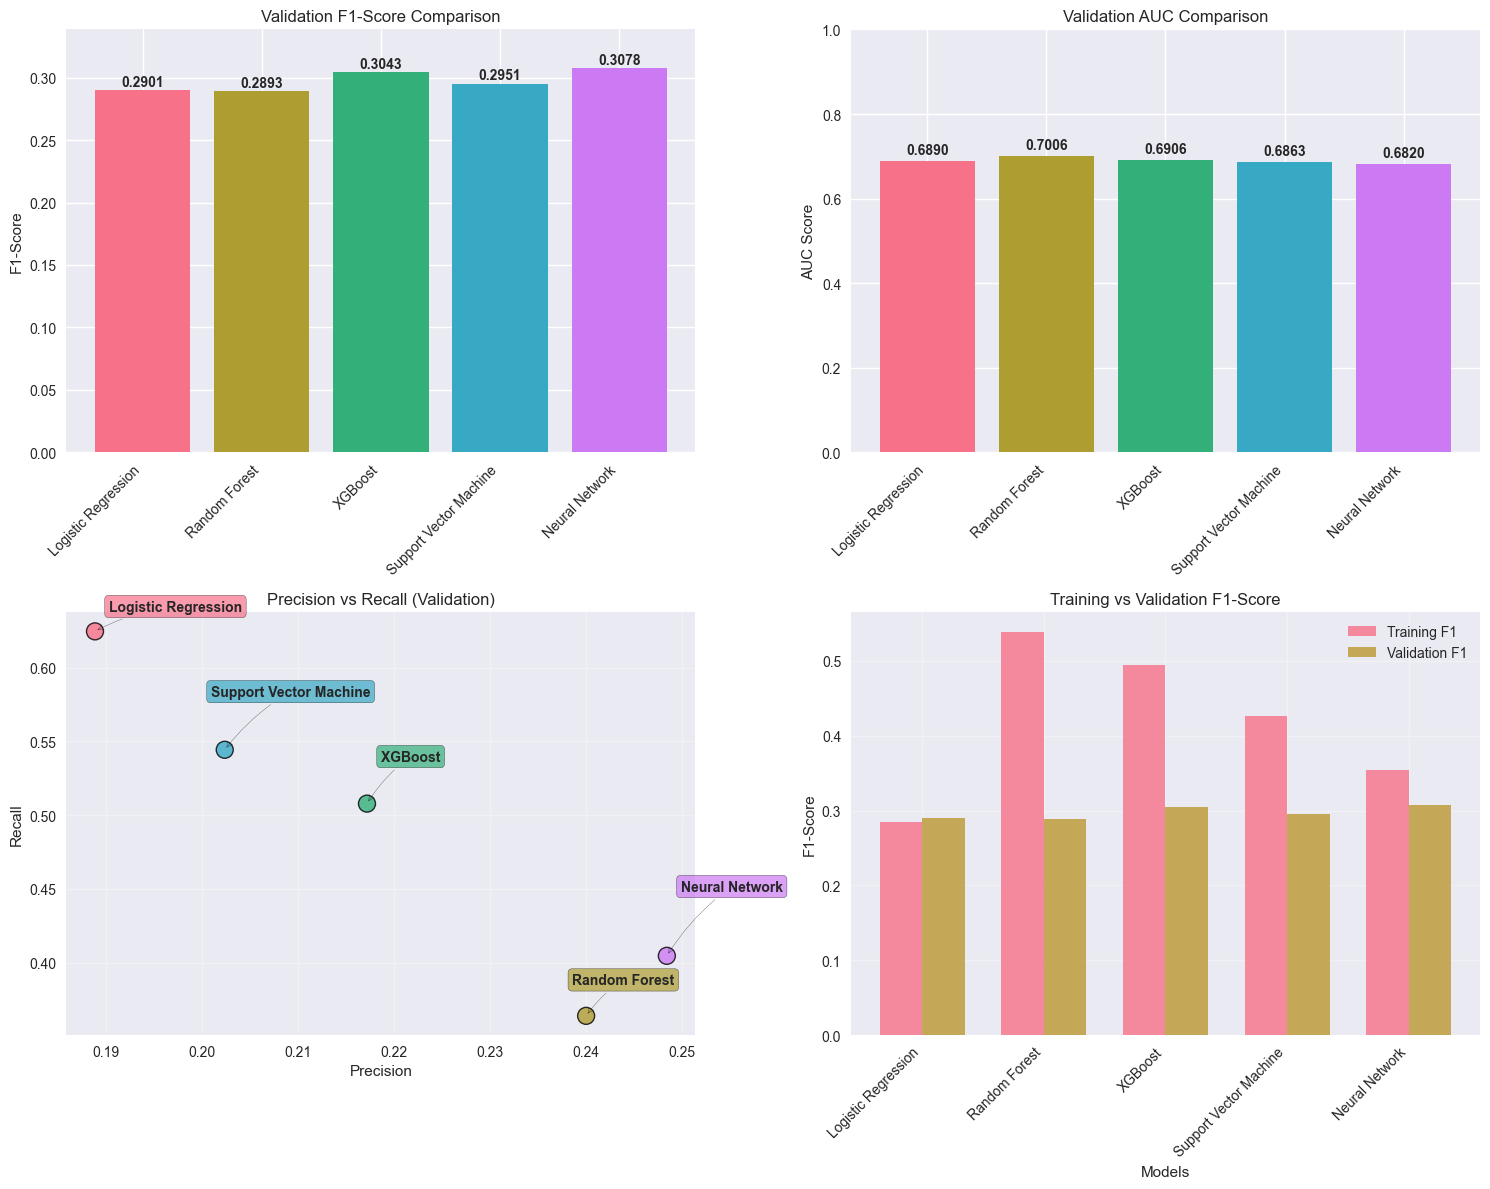


Model comparison visualization completed


In [15]:
# Model comparison summary
print("BASELINE MODELS COMPARISON")
print("=" * 60)

# Create results DataFrame
results_df = pd.DataFrame(model_results)
results_df = results_df.round(4)

print("Model Performance Summary:")
print(results_df[['model_name', 'cv_f1_mean', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1', 'val_auc']].to_string(index=False))

# Find best model by validation F1-score
best_model_idx = results_df['val_f1'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'model_name']
best_f1 = results_df.loc[best_model_idx, 'val_f1']

print(f"\nBest performing model: {best_model_name} (F1-score: {best_f1:.4f})")

# Performance comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Validation F1-scores
ax1 = axes[0, 0]
bars = ax1.bar(results_df['model_name'], results_df['val_f1'], 
               color=sns.color_palette("husl", len(results_df)))
ax1.set_title('Validation F1-Score Comparison')
ax1.set_ylabel('F1-Score')
ax1.set_ylim(0, max(results_df['val_f1']) * 1.1)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar, val in zip(bars, results_df['val_f1']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Validation AUC scores
ax2 = axes[0, 1]
bars2 = ax2.bar(results_df['model_name'], results_df['val_auc'],
                color=sns.color_palette("husl", len(results_df)))
ax2.set_title('Validation AUC Comparison')
ax2.set_ylabel('AUC Score')
ax2.set_ylim(0, 1)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Add value labels
for bar, val in zip(bars2, results_df['val_auc']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Precision vs Recall
ax3 = axes[1, 0]
colors = sns.color_palette("husl", len(results_df))
scatter = ax3.scatter(results_df['val_precision'], results_df['val_recall'], 
                     s=150, c=colors, alpha=0.8, edgecolors='black', linewidth=1)
ax3.set_xlabel('Precision')
ax3.set_ylabel('Recall')
ax3.set_title('Precision vs Recall (Validation)')
ax3.grid(True, alpha=0.3)

# Add model name labels with improved positioning
for i, model in enumerate(results_df['model_name']):
    # Use different offsets for better spacing
    offset_x = 10 if i % 2 == 0 else -10
    offset_y = 15 + (i * 8)  # Stagger vertically
    
    ax3.annotate(model, (results_df['val_precision'][i], results_df['val_recall'][i]),
                xytext=(offset_x, offset_y), textcoords='offset points', 
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[i], alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1', 
                              color='black', alpha=0.6))

# 4. Training vs Validation F1 (overfitting check)
ax4 = axes[1, 1]
x_pos = np.arange(len(results_df))
width = 0.35

train_bars = ax4.bar(x_pos - width/2, results_df['train_f1'], width, 
                    label='Training F1', alpha=0.8)
val_bars = ax4.bar(x_pos + width/2, results_df['val_f1'], width,
                  label='Validation F1', alpha=0.8)

ax4.set_xlabel('Models')
ax4.set_ylabel('F1-Score')
ax4.set_title('Training vs Validation F1-Score')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(results_df['model_name'], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nModel comparison visualization completed")

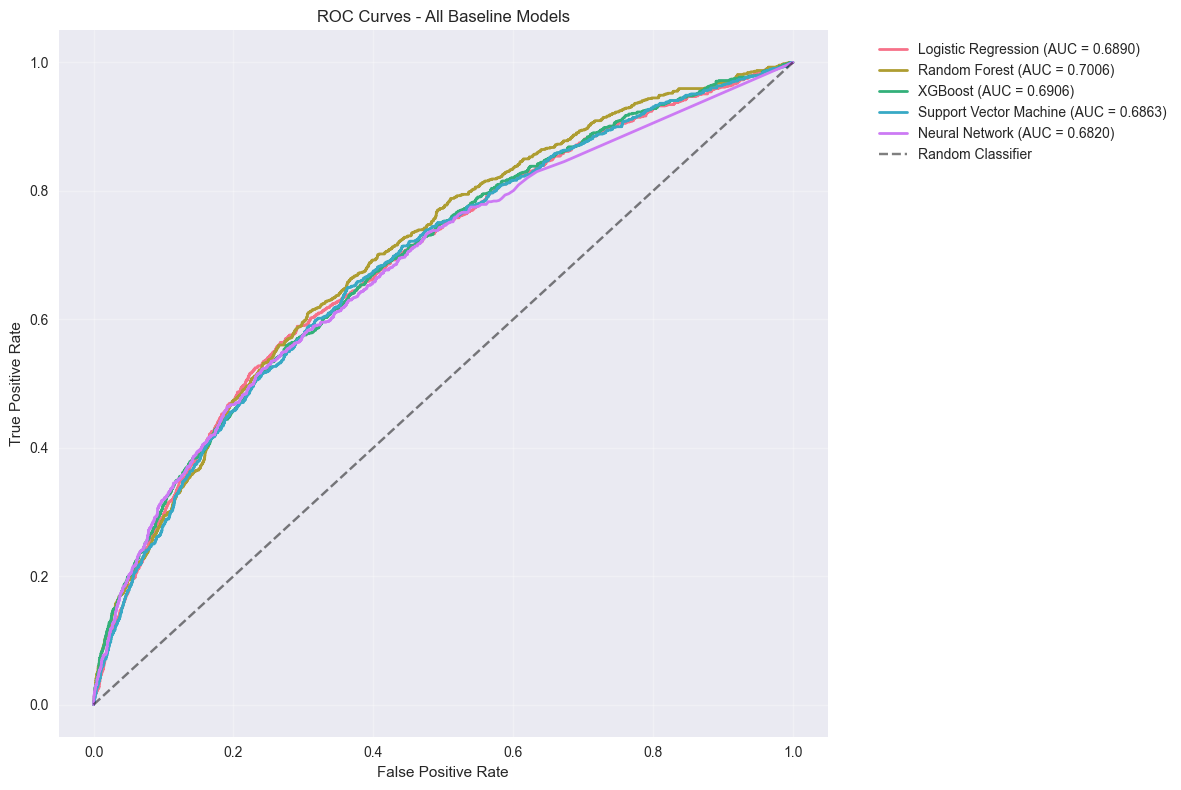

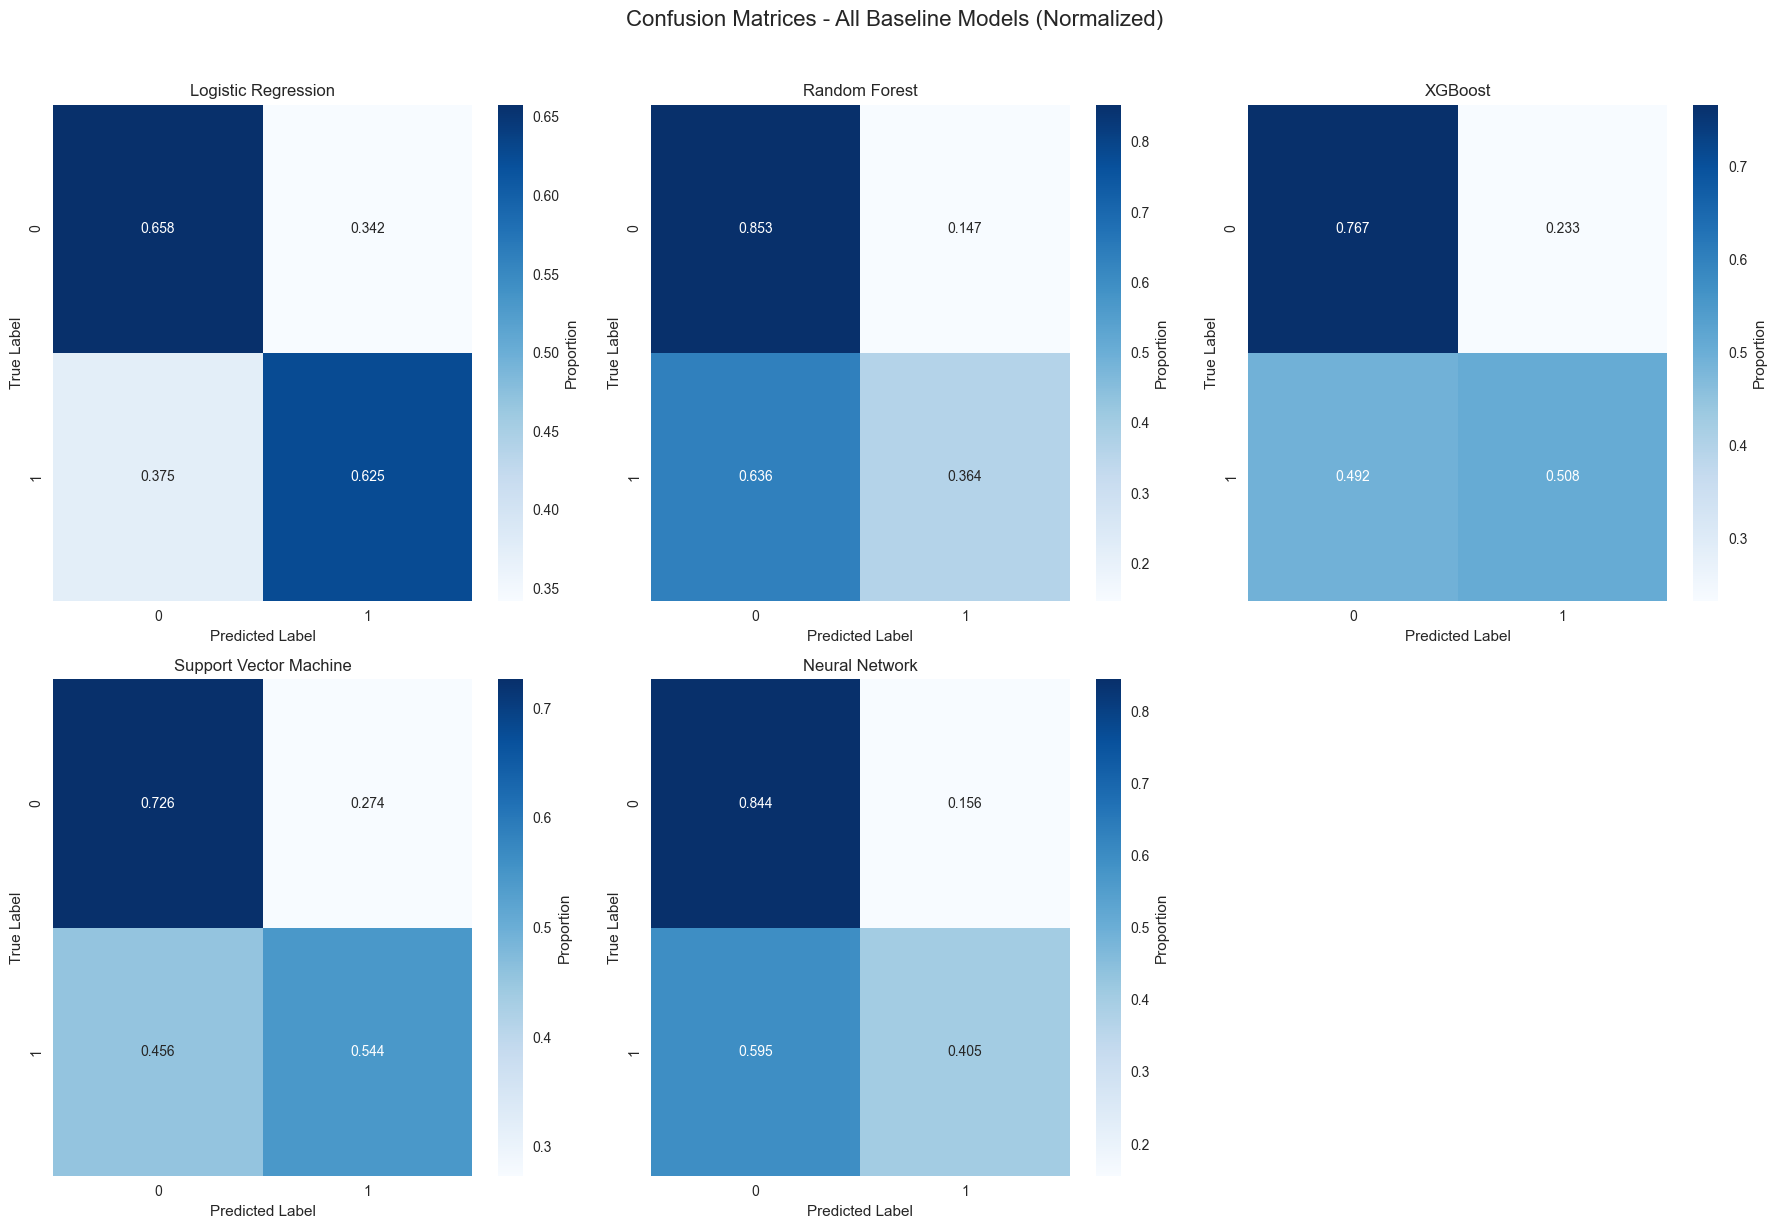

ROC curves and confusion matrices visualization completed


In [16]:
# ROC Curves for all models
plt.figure(figsize=(12, 8))

colors = sns.color_palette("husl", len(model_predictions))
for i, (model_name, (y_pred, y_pred_proba)) in enumerate(model_predictions.items()):
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    auc = roc_auc_score(y_val, y_pred_proba)
    plt.plot(fpr, tpr, color=colors[i], linewidth=2, 
             label=f'{model_name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Baseline Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, (model_name, (y_pred, y_pred_proba)) in enumerate(model_predictions.items()):
    cm = confusion_matrix(y_val, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
                ax=axes[i], cbar_kws={'label': 'Proportion'})
    axes[i].set_title(f'{model_name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

# Hide the last subplot if there are fewer than 6 models
if len(model_predictions) < 6:
    axes[-1].axis('off')

plt.suptitle('Confusion Matrices - All Baseline Models (Normalized)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("ROC curves and confusion matrices visualization completed")

In [17]:
# Classification reports for all models
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 60)

for model_name, (y_pred, y_pred_proba) in model_predictions.items():
    print(f"\n{model_name}:")
    print("-" * 40)
    print(classification_report(y_val, y_pred, target_names=['No Heart Risk', 'Heart Risk']))

print("Classification reports completed")

DETAILED CLASSIFICATION REPORTS

Logistic Regression:
----------------------------------------
               precision    recall  f1-score   support

No Heart Risk       0.93      0.66      0.77      7517
   Heart Risk       0.19      0.62      0.29       959

     accuracy                           0.65      8476
    macro avg       0.56      0.64      0.53      8476
 weighted avg       0.85      0.65      0.72      8476


Random Forest:
----------------------------------------
               precision    recall  f1-score   support

No Heart Risk       0.91      0.85      0.88      7517
   Heart Risk       0.24      0.36      0.29       959

     accuracy                           0.80      8476
    macro avg       0.58      0.61      0.59      8476
 weighted avg       0.84      0.80      0.81      8476


XGBoost:
----------------------------------------
               precision    recall  f1-score   support

No Heart Risk       0.92      0.77      0.84      7517
   Heart Risk       

## Misclassified Samples Analysis

In [19]:
# Analyze misclassified samples for the best performing model
print("MISCLASSIFIED SAMPLES ANALYSIS")
print("=" * 50)

# Use the best model for detailed analysis
best_model_predictions = model_predictions[best_model_name]
best_y_pred = best_model_predictions[0]
best_y_pred_proba = best_model_predictions[1]

# Identify misclassified samples
misclassified_idx = np.where(y_val != best_y_pred)[0]
correctly_classified_idx = np.where(y_val == best_y_pred)[0]

print(f"Analyzing misclassified samples for: {best_model_name}")
print(f"Total validation samples: {len(y_val)}")
print(f"Correctly classified: {len(correctly_classified_idx)} ({len(correctly_classified_idx)/len(y_val)*100:.1f}%)")
print(f"Misclassified: {len(misclassified_idx)} ({len(misclassified_idx)/len(y_val)*100:.1f}%)")

# Analyze types of errors
# False Positives: Predicted 1, Actual 0
fp_idx = np.where((best_y_pred == 1) & (y_val == 0))[0]
# False Negatives: Predicted 0, Actual 1  
fn_idx = np.where((best_y_pred == 0) & (y_val == 1))[0]

print(f"\nError breakdown:")
print(f"False Positives (predicted risk, actually no risk): {len(fp_idx)}")
print(f"False Negatives (predicted no risk, actually risk): {len(fn_idx)}")

# Sample analysis for False Positives
if len(fp_idx) > 0:
    print(f"\nFALSE POSITIVES ANALYSIS (sample of {min(10, len(fp_idx))}):") 
    
    fp_sample_idx = fp_idx[:10] if len(fp_idx) >= 10 else fp_idx
    fp_samples = X_val.iloc[fp_sample_idx]
    fp_probabilities = best_y_pred_proba[fp_sample_idx]
    
    print("Prediction probabilities for false positives:")
    for i, (idx, prob) in enumerate(zip(fp_sample_idx, fp_probabilities)):
        print(f"  Sample {i+1}: Predicted probability = {prob:.4f}")
    
    # Feature analysis for false positives
    fp_feature_means = fp_samples.mean()
    all_feature_means = X_val.mean()
    
    print(f"\nFeature comparison (False Positives vs All Validation):")
    feature_diff = pd.DataFrame({
        'feature': feature_names,
        'fp_mean': fp_feature_means,
        'all_mean': all_feature_means,
        'difference': fp_feature_means - all_feature_means,
        'abs_difference': np.abs(fp_feature_means - all_feature_means)
    }).sort_values('abs_difference', ascending=False)
    
    print("Top 10 features with largest differences in FP samples:")
    for i, (_, row) in enumerate(feature_diff.head(10).iterrows()):
        print(f"  {i+1:2d}. {row['feature']:20s}: FP={row['fp_mean']:7.3f}, All={row['all_mean']:7.3f}, Diff={row['difference']:+7.3f}")

# Sample analysis for False Negatives  
if len(fn_idx) > 0:
    print(f"\nFALSE NEGATIVES ANALYSIS (sample of {min(10, len(fn_idx))}):")
    print(f"\nFALSE NEGATIVES ANALYSIS (sample of {min(10, len(fn_idx))}):") 
    
    fn_sample_idx = fn_idx[:10] if len(fn_idx) >= 10 else fn_idx
    fn_samples = X_val.iloc[fn_sample_idx]
    fn_probabilities = best_y_pred_proba[fn_sample_idx]
    
    print("Prediction probabilities for false negatives:")
    for i, (idx, prob) in enumerate(zip(fn_sample_idx, fn_probabilities)):
        print(f"  Sample {i+1}: Predicted probability = {prob:.4f}")
    
    # Feature analysis for false negatives
    fn_feature_means = fn_samples.mean()
    
    print(f"\nFeature comparison (False Negatives vs All Validation):")
    feature_diff_fn = pd.DataFrame({
        'feature': feature_names,
        'fn_mean': fn_feature_means,
        'all_mean': all_feature_means,
        'difference': fn_feature_means - all_feature_means,
        'abs_difference': np.abs(fn_feature_means - all_feature_means)
    }).sort_values('abs_difference', ascending=False)
    
    print("Top 10 features with largest differences in FN samples:")
    for i, (_, row) in enumerate(feature_diff_fn.head(10).iterrows()):
        print(f"  {i+1:2d}. {row['feature']:20s}: FN={row['fn_mean']:7.3f}, All={row['all_mean']:7.3f}, Diff={row['difference']:+7.3f}")

print(f"\n Misclassified samples analysis completed")

MISCLASSIFIED SAMPLES ANALYSIS
Analyzing misclassified samples for: Neural Network
Total validation samples: 8476
Correctly classified: 6731 (79.4%)
Misclassified: 1745 (20.6%)

Error breakdown:
False Positives (predicted risk, actually no risk): 1174
False Negatives (predicted no risk, actually risk): 571

FALSE POSITIVES ANALYSIS (sample of 10):
Prediction probabilities for false positives:
  Sample 1: Predicted probability = 0.7250
  Sample 2: Predicted probability = 0.7248
  Sample 3: Predicted probability = 0.7291
  Sample 4: Predicted probability = 0.7277
  Sample 5: Predicted probability = 0.6286
  Sample 6: Predicted probability = 0.7282
  Sample 7: Predicted probability = 0.7300
  Sample 8: Predicted probability = 0.7005
  Sample 9: Predicted probability = 0.7304
  Sample 10: Predicted probability = 0.6834

Feature comparison (False Positives vs All Validation):
Top 10 features with largest differences in FP samples:
   1. dosprt              : FP= -0.834, All= -0.009, Diff= -

## Final Model Summary and Recommendations

In [20]:
# Final summary and model selection recommendations
print("FINAL BASELINE MODELS SUMMARY")
print("=" * 60)

# Save comprehensive results
comprehensive_results = pd.DataFrame(model_results)

# Rank models by validation F1-score
comprehensive_results['rank'] = comprehensive_results['val_f1'].rank(ascending=False)
comprehensive_results = comprehensive_results.sort_values('val_f1', ascending=False)

print("FINAL MODEL RANKINGS (by Validation F1-Score):")
print(comprehensive_results[['rank', 'model_name', 'val_f1', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc']].to_string(index=False))

# Key insights and recommendations
print(f"\nKEY INSIGHTS:")
print(f"1. Best performing model: {comprehensive_results.iloc[0]['model_name']}")
print(f"   - F1-Score: {comprehensive_results.iloc[0]['val_f1']:.4f}")
print(f"   - AUC: {comprehensive_results.iloc[0]['val_auc']:.4f}")
print(f"   - Accuracy: {comprehensive_results.iloc[0]['val_accuracy']:.4f}")

# Check for overfitting
overfitting_check = []
for _, row in comprehensive_results.iterrows():
    if not pd.isna(row['train_f1']):
        train_val_diff = row['train_f1'] - row['val_f1']
        overfitting_check.append({
            'model': row['model_name'],
            'train_val_diff': train_val_diff,
            'overfitting': train_val_diff > 0.1
        })

print(f"\n2. Overfitting Analysis:")
for check in overfitting_check:
    status = "High overfitting detected" if check['overfitting'] else "Acceptable performance"
    print(f"   - {check['model']:20s}: Train-Val diff = {check['train_val_diff']:+.4f} ({status})")

print(f"\n3. Class Imbalance Handling:")
print(f"   - All models used balanced class weights or equivalent")
print(f"   - Dataset has {np.mean(y_val == 0)*100:.1f}% negative class, {np.mean(y_val == 1)*100:.1f}% positive class")

print("\nRECOMMENDATIONS FOR NEXT STEPS:")
print(f"1. Hyperparameter tuning for top 3 performing models")
print(f"2. Feature engineering based on misclassified samples analysis")
print(f"3. Ensemble methods combining best performers")
print(f"4. Advanced techniques: Stacking, Bayesian optimization")
print(f"5. Cross-validation with stratification for final model selection")

# Save results for future use
results_output_dir = "../results"
os.makedirs(results_output_dir, exist_ok=True)

# Save comprehensive metrics
comprehensive_results.to_csv(f"{results_output_dir}/comprehensive_model_metrics.csv", index=False)

# Save model comparison for further analysis
model_comparison = {
    'best_model': best_model_name,
    'best_f1_score': comprehensive_results.iloc[0]['val_f1'],
    'all_models': comprehensive_results['model_name'].tolist(),
    'evaluation_date': datetime.now().strftime('%Y-%m-%d %H:%M')
}

with open(f"{results_output_dir}/model_comparison_summary.txt", 'w') as f:
    f.write("HEART DISEASE RISK PREDICTION - BASELINE MODELS SUMMARY\n")
    f.write("="*60 + "\n\n")
    f.write(f"Best Model: {model_comparison['best_model']}\n")
    f.write(f"Best F1-Score: {model_comparison['best_f1_score']:.4f}\n")
    f.write(f"Evaluation Date: {model_comparison['evaluation_date']}\n\n")
    f.write("All Models Tested:\n")
    for i, model in enumerate(model_comparison['all_models'], 1):
        f.write(f"{i}. {model}\n")

print(f"\nResults saved to:")
print(f"   - {results_output_dir}/comprehensive_model_metrics.csv")
print(f"   - {results_output_dir}/model_comparison_summary.txt")

print(f"\nBASELINE MODELING PHASE COMPLETED SUCCESSFULLY!")
print(f"Ready for hyperparameter tuning and advanced modeling techniques")

FINAL BASELINE MODELS SUMMARY
FINAL MODEL RANKINGS (by Validation F1-Score):
 rank             model_name   val_f1  val_accuracy  val_precision  val_recall  val_auc
  1.0         Neural Network 0.307814      0.794125       0.248399    0.404588 0.681975
  2.0                XGBoost 0.304280      0.737258       0.217217    0.507821 0.690637
  3.0 Support Vector Machine 0.295082      0.705757       0.202404    0.544317 0.686316
  4.0    Logistic Regression 0.290073      0.654082       0.188899    0.624609 0.688960
  5.0          Random Forest 0.289266      0.797664       0.240028    0.363921 0.700613

KEY INSIGHTS:
1. Best performing model: Neural Network
   - F1-Score: 0.3078
   - AUC: 0.6820
   - Accuracy: 0.7941

2. Overfitting Analysis:
   - Neural Network      : Train-Val diff = +0.0466 (Acceptable performance)
   - XGBoost             : Train-Val diff = +0.1898 (High overfitting detected)
   - Support Vector Machine: Train-Val diff = +0.1313 (High overfitting detected)
   - Logistic